In [1]:
# autoreloadを有効化
%load_ext autoreload
%autoreload 2

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from qulacs import QuantumCircuit
from qulacs.gate import CNOT
from qulacsvis import circuit_drawer

from qc_ft_prob import fourier_series_coeffs, build_Uc_circuit_from_ck_cascade, build_c_tilde_amplitudes_from_ck, iqft_circuit

# フーリエ変換

Text(0, 0.5, 'c_k')

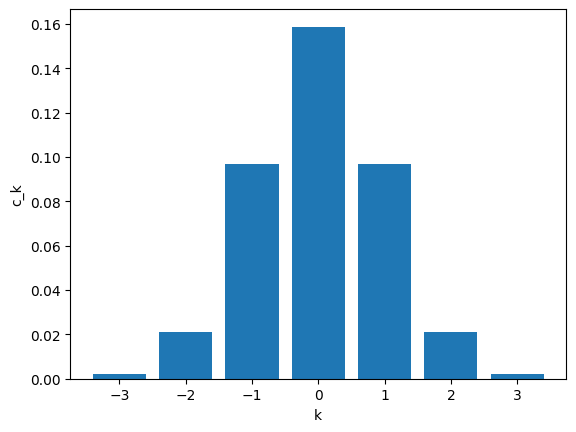

In [29]:
# ガウス関数
sigma = 1.0
func = lambda x: 1/np.sqrt(2*np.pi*sigma*sigma) * np.exp(-x*x / (2*sigma*sigma))

# フーリエ求数計算
# サンプリング範囲 = (-np.pi, +np.pi)を10点
T = 2 * np.pi
x0 = -T/2
# フーリエ求数は [+M,...,-M]の範囲
m = 2
M = 2**m - 1
# 全体のqubit数
n = 5

# フーリエ係数の決定と量子状態へのエンコーディング
ks, cs, _ = fourier_series_coeffs(func, x0=-T/2, T=T, M=M)
plt.bar(ks, cs.real)
plt.xlabel("k")
plt.ylabel("c_k")

# 振幅への変換

Text(0, 0.5, 'c_k')

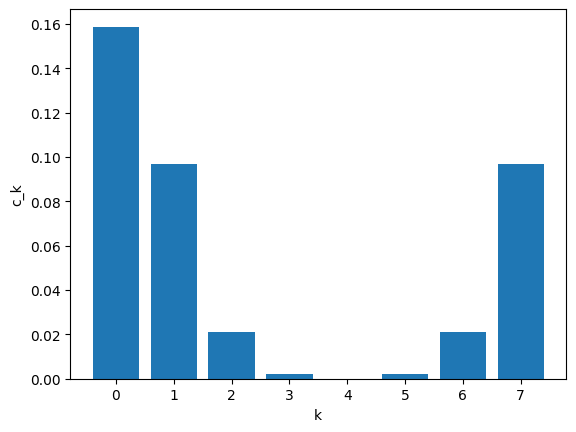

In [30]:
amps, meta = build_c_tilde_amplitudes_from_ck(ks, cs, m=m)
plt.bar(range(len(amps)), amps.real)
plt.xlabel("k")
plt.ylabel("c_k")

# 量子計算

## Step 1: Uc

<BarContainer object of 8 artists>

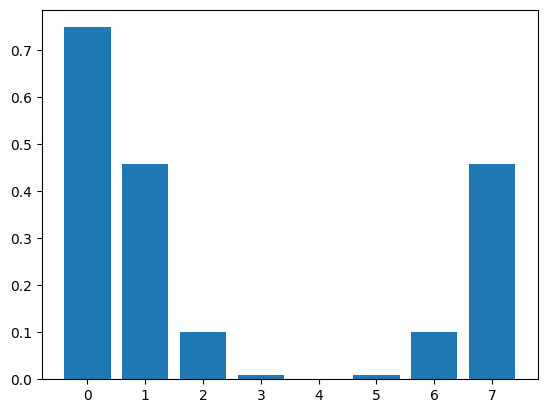

In [31]:
# 実際に状態 Uc|0..0> を確認
from qulacs import QuantumState

state = QuantumState(m+1)
state.set_zero_state()

Uc_circuit, meta = build_Uc_circuit_from_ck_cascade(ks, cs)

Uc_circuit.update_quantum_state(state)
psi = state.get_vector()
plt.bar(range(len(psi)), psi.real)

# n qbitへの拡張

<BarContainer object of 32 artists>

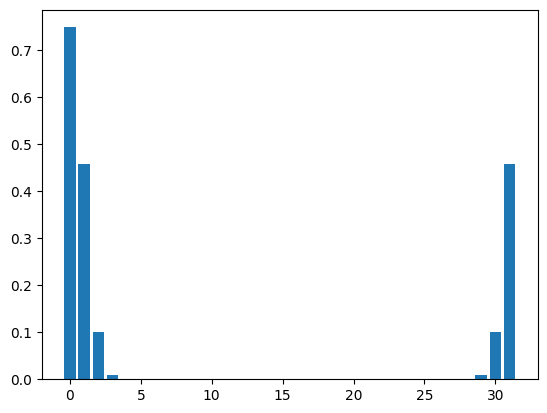

In [32]:
circ = QuantumCircuit(n)

# まず 0〜m の m+1 qubit に Uc を埋め込む
circ.merge_circuit(Uc_circuit)  # qubit 番号はそのまま再利用される想定

# 次に CNOT を追加
control = m
for target in range(m+1, n):
    circ.add_gate(CNOT(control, target))

state = QuantumState(n)
state.set_zero_state()
circ.update_quantum_state(state)
psi = state.get_vector()

circuit_drawer(circ, "mpl")
plt.show()
plt.bar(range(len(psi)), psi.real)

# 逆フーリエ変換

<BarContainer object of 32 artists>

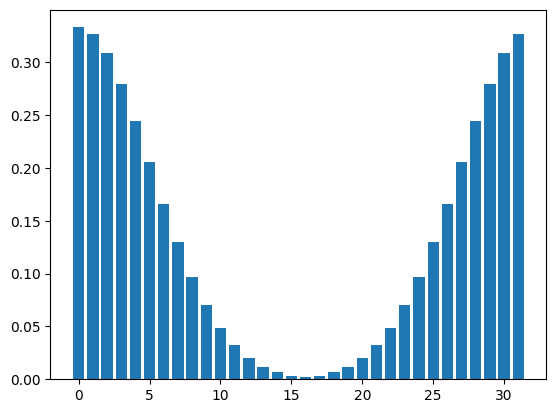

In [33]:
circ = QuantumCircuit(n)

# まず 0〜m の m+1 qubit に Uc を埋め込む
circ.merge_circuit(Uc_circuit)  # qubit 番号はそのまま再利用される想定

# 次に CNOT を追加
control = m
for target in range(m+1, n):
    circ.add_gate(CNOT(control, target))

# IQFT
circ.merge_circuit(iqft_circuit(n))

state = QuantumState(n)
state.set_zero_state()
circ.update_quantum_state(state)
psi = state.get_vector()

circuit_drawer(circ, "mpl")
plt.show()
plt.bar(range(len(psi)), psi.real)

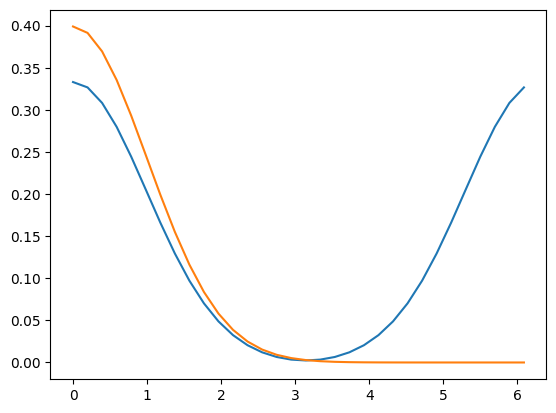

In [35]:
xs = np.arange(len(psi)) / (2**n) * T
plt.plot(xs, psi.real)
plt.plot(xs, func(xs))